In [ ]:
!pip install keras
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install lime
!pip install json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=bc52ddb96b8f1fae7e69b1faa0fd27c6f7c07fcb7904a46d826449a04db9ebd4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERRO

In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shutil
import random
import numpy as np
import json
import zipfile
import os
import pandas as pd
import PIL
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lime
from lime import lime_image
from PIL import Image

In [ ]:
!wget "http://seppe.net/aa/assignment2/images.zip"
!7z x images.zip

--2023-05-25 09:12:51--  http://seppe.net/aa/assignment2/images.zip
Resolving seppe.net (seppe.net)... 37.139.1.16
Connecting to seppe.net (seppe.net)|37.139.1.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21223409265 (20G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  19.77G   164MB/s    in 2m 7s   

2023-05-25 09:14:58 (159 MB/s) - ‘images.zip’ saved [21223409265/21223409265]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 21223409265 bytes (20 GiB)

Extracting archive: images.zip
  3% 4096 Open              --
Path = images.zip
Type = zip
Physical Size = 21223409265
64-bit = +

  0%      0% 163 - images/1001867.jpg       

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
! rm images.zip

In [ ]:
import os
images_path = '/content/images'
dataset_path = '/content/gdrive/My Drive/dataset.json'

Extract the price categories and store them in a library where they are linked to images. (We will later need this as a dataframe)

In [ ]:
with open(dataset_path, "r") as f:
    data = json.load(f)
price_categories = {}
image_ids = []
for item in data:
    # Check if 'price_category' key is present in the 'item' dictionary
    if 'price_category' in item and item['price_category'] is not None:
        # Extract the price category
        price_category = item['price_category']['label']
        # Extract the image IDs from the "full_images" list and map them to their price category
        for img in item["more_details"]["full_images"]:
            image_id = img["image_id"]
            image_ids.append(image_id)
            price_categories[image_id] = price_category


Now I have a list of image id's and a library of price categories.
The file names of the images are just the id with .jpg behind it.
I want to create the training, validation and test set.
For this I need to make a pandas data frame with two columns, with the image file names and one with the categories.

First, we shuffle the image id's and then split them up in training, validation and test set lists of image id's.(The training, validation, test sizes are 70%, 20% and 10%. We could, however **change these values 0.07, 0.02, 0.01 to lower values if we want to use less of the data**.)

In [ ]:
random.shuffle(image_ids)  # shuffle image id's

train_size = 0.07
val_size = 0.02
test_size = 0.01

train_image_ids = image_ids[:int(len(image_ids) * train_size)]
val_image_ids = image_ids[int(len(image_ids) * train_size):int(len(image_ids) * (train_size + val_size))]
test_image_ids = image_ids[int(len(image_ids) * (train_size + val_size)):int(len(image_ids) * (train_size + val_size + test_size))]

Now we create lists of the filenames of these images.

In [ ]:
train_filenames = [f"{image_id}.jpg" for image_id in train_image_ids]
val_filenames = [f"{image_id}.jpg" for image_id in val_image_ids]
test_filenames = [f"{image_id}.jpg" for image_id in test_image_ids]


Now, we create a pandas dataframe with two columns: "filename" and "price_category".

In [ ]:
train_df = pd.DataFrame(
    {"id": train_filenames, "label": [price_categories[image_id] for image_id in train_image_ids]})
val_df = pd.DataFrame(
    {"id": val_filenames, "label": [price_categories[image_id] for image_id in val_image_ids]})
test_df = pd.DataFrame(
    {"id": test_filenames, "label": [price_categories[image_id] for image_id in test_image_ids]})

We set the paths for the training, validation, and test data directories and create the directories.

We set the paths for the training, validation, and test data directories and create the directories.

In [ ]:
# delete the directories if they are there already
if os.path.exists('/content/images/train'):
    shutil.rmtree('/content/images/train')
else:
    print(f"The folder '{'/content/images/train'}' does not exist yet.")

if os.path.exists('/content/images/val'):
    shutil.rmtree('/content/images/val')
else:
    print(f"The folder '{'/content/images/val'}' does not exist yet.")

if os.path.exists('/content/images/test'):
    shutil.rmtree('/content/images/test')
else:
    print(f"The folder '{'/content/images/test'}' does not exist yet.")

# Set the paths for the training, validation, and test data directories
train_data_dir = os.path.join(images_path, "train")
val_data_dir = os.path.join(images_path, "val")
test_data_dir = os.path.join(images_path, "test")

# Create the directories if they don't exist already
!mkdir -p "{train_data_dir}"
!mkdir -p "{val_data_dir}"
!mkdir -p "{test_data_dir}"

The folder '/content/images/train' does not exist yet.
The folder '/content/images/val' does not exist yet.
The folder '/content/images/test' does not exist yet.


We move the image files to the appropriate directories.

In [ ]:
from PIL import Image

def is_image_corrupted(image_path):
    try:
        Image.open(image_path)
        return False
    except (IOError, SyntaxError):
        return True


In [ ]:
for filename in train_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(train_data_dir, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        print(f"corrupted image: {filename}")
    else:
        shutil.move(src_path, dst_path)

for filename in val_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(val_data_dir, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        print(f"corrupted image: {filename}")
    else:
        shutil.move(src_path, dst_path) 

for filename in test_filenames:
    src_path = os.path.join(images_path, filename)
    dst_path = os.path.join(test_data_dir, filename)
    is_corrupted = is_image_corrupted(src_path)
    if is_corrupted:
        print(f"corrupted image: {filename}")
    else:
        shutil.move(src_path, dst_path)

Now we want to preprocess the data and then generate it.


We first define the image dimensions and the batch size. **(Change this, see what works best)**

In [ ]:
img_width, img_height = 224, 224
batch_size = 32

We use ImageDataGenerator for preprocessing including rotation augmentation.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=20, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

We generate the training, validation, and testing datasets.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        directory='/content/images/train',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_df,
        directory='/content/images/val',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,
        directory='/content/images/test',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=False,
        class_mode="categorical",
        batch_size=32)

Found 8096 validated image filenames belonging to 4 classes.
Found 2313 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


Now we can finally build our Neural Network. We created one by hand at first, and then used a pretrained model (VGG16) to compare the results.

Define the CNN structure.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

Compile the model.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model.(**Number of epochs can be changed**)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=5, 
                              validation_data=validation_generator, validation_steps=validation_generator.samples // batch_size)

<ipython-input-20-c991f2b96346>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=5,


Epoch 1/5
253/253 [==============================] - 390s 1s/step - loss: 1.2441 - accuracy: 0.4102 - val_loss: 1.2290 - val_accuracy: 0.4214
Epoch 2/5
253/253 [==============================] - 372s 1s/step - loss: 1.2115 - accuracy: 0.4254 - val_loss: 1.2249 - val_accuracy: 0.4206
Epoch 3/5
253/253 [==============================] - 361s 1s/step - loss: 1.2105 - accuracy: 0.4256 - val_loss: 1.2393 - val_accuracy: 0.4314
Epoch 4/5
253/253 [==============================] - 333s 1s/step - loss: 1.2028 - accuracy: 0.4345 - val_loss: 1.2272 - val_accuracy: 0.4345
Epoch 5/5
253/253 [==============================] - 364s 1s/step - loss: 1.1953 - accuracy: 0.4379 - val_loss: 1.2263 - val_accuracy: 0.4266


Evaluate the model.

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


<ipython-input-21-416c9d65b6c8>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test accuracy: 0.4479166567325592
Test loss: 1.1987321376800537


Interpreter LIME


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-61-8c593b07f033>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


(-0.5, 223.5, 223.5, -0.5)

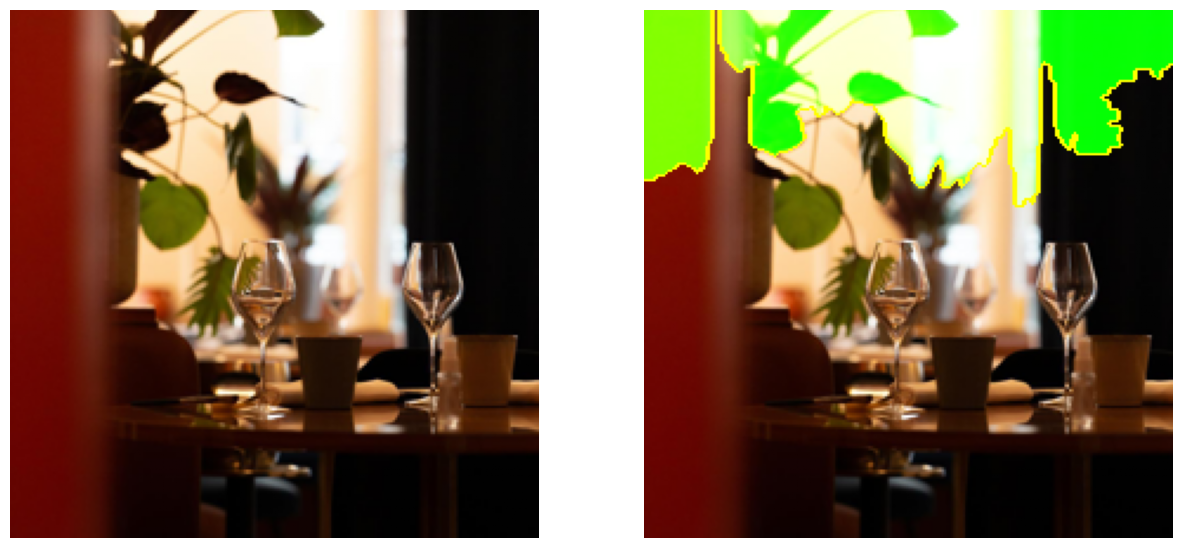

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
!pip install scikit-image
from matplotlib import cm

# Modify the colormap
colormap = cm.get_cmap('viridis')
explainer = lime_image.LimeImageExplainer()


def predict_wrapper(images):
    # This function is a wrapper around the model's prediction function
    # It takes in a batch of images (N, 224, 224, 3) and returns the predicted probabilities (N, 5)
    # Modify this function according to your specific model's prediction function
    return model.predict(images)


# Get an example image from the validation set
example_image_path = os.path.join(val_data_dir, val_filenames[100])
example_image = Image.open(example_image_path).resize((224, 224))

# Explain the model's prediction for the example image
explanation = explainer.explain_instance(np.array(example_image), predict_wrapper, top_labels=5)

# Show the LIME visualization for the explanation
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Now, we do the same thing but with the pretrained model VGG16.

We first preprocess and generate.

In [ ]:
# preprocessing according to VGG16
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(rescale=1. / 255,preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1. / 255,preprocessing_function=preprocess_input)

# Generate the training, validation, and testing datasets (I followed the instructions on https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/)
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        directory='/content/images/train',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=256)

validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_df,
        directory='/content/images/val',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        batch_size=256)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df,
        directory='/content/images/test',
        target_size=(224,224),
        x_col="id",
        y_col="label",
        seed=42,
        shuffle=False,
        class_mode="categorical",
        batch_size=256)


Found 8096 validated image filenames belonging to 4 classes.
Found 2313 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


Load without the top layer input_shape(img_width, img_height, 3) (the 3 is for the colors rbg).

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
    # This is to make sure we don't train these layers

58889256/58889256 [==============================] - 2s 0us/step


We add a new output layer with 4 categories. Then we create the new model with the pretrained layers and our new output layer.

In [ ]:
x = Flatten()(vgg_model.output)
output_layer = Dense(4, activation='softmax')(x)

model_VGG = Model(inputs=vgg_model.input, outputs=output_layer)

Compile the model.

In [ ]:
model_VGG.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model. (**Number of epochs can be changed**)

In [ ]:
history = model_VGG.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=1,
                              validation_data=validation_generator, validation_steps=validation_generator.samples // batch_size)

<ipython-input-32-858553531689>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_VGG.fit_generator(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=1,


31/31 [==============================] - 424s 13s/step - loss: 1.5599 - accuracy: 0.3520 - val_loss: 1.3595 - val_accuracy: 0.4280


Evaluate the model.


In [ ]:
test_loss, test_acc = model_VGG.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

<ipython-input-33-bee26fdafaac>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_VGG.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test accuracy: 0.4462890625
Test loss: 1.3042035102844238


LIME interpreter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-59-63ffca1c1e50>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


(-0.5, 223.5, 223.5, -0.5)

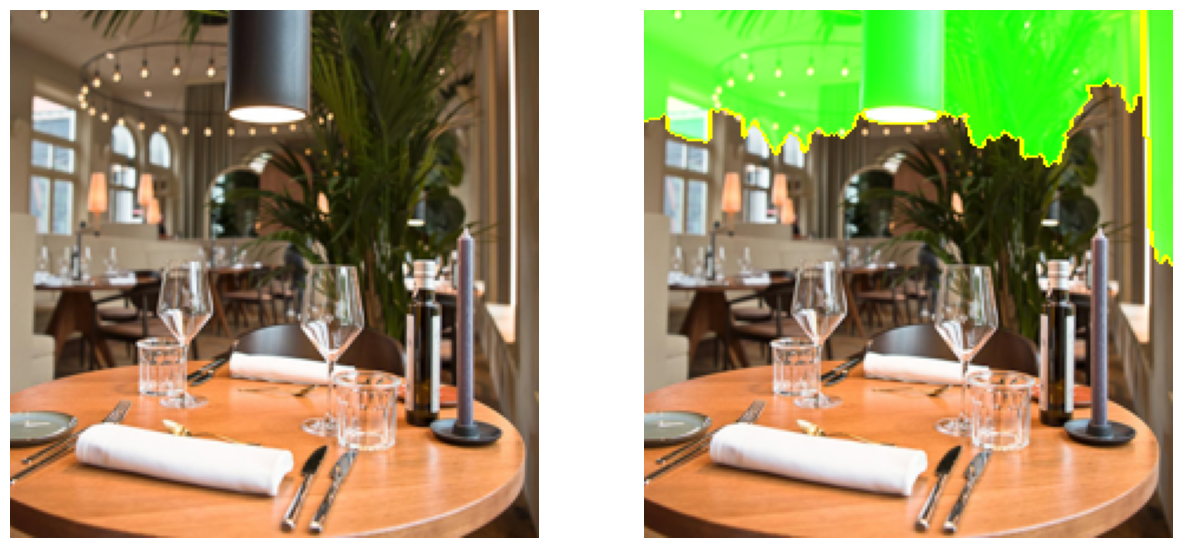

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
!pip install scikit-image
from matplotlib import cm

# Modify the colormap
colormap = cm.get_cmap('viridis')
explainer = lime_image.LimeImageExplainer()


def predict_wrapper(images):
    # This function is a wrapper around the model's prediction function
    # It takes in a batch of images (N, 224, 224, 3) and returns the predicted probabilities (N, 5)
    # Modify this function according to your specific model's prediction function
    return model.predict(images)


# Get an example image from the validation set
example_image_path = os.path.join(val_data_dir, val_filenames[2])
example_image = Image.open(example_image_path).resize((224, 224))

# Explain the model's prediction for the example image
explanation = explainer.explain_instance(np.array(example_image), predict_wrapper, top_labels=5)

# Show the LIME visualization for the explanation
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Now, for the ResNet50 pretrained model

In [ ]:
from keras.applications import ResNet50

# Preprocessing
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=90,
    brightness_range=[0.1, 0.7],
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)

# Generate the training, validation, and testing datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/images/train',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=True,
    class_mode="categorical",
    batch_size=64
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/images/val',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=True,
    class_mode="categorical",
    batch_size=64
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/images/test',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=False,
    class_mode="categorical",
    batch_size=64
)

# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the ResNet50 model
x = Flatten()(resnet_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

# Create the final model
model_resnet = Model(inputs=resnet_model.input, outputs=output_layer)

# Compile and train the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Found 8096 validated image filenames belonging to 4 classes.
Found 2313 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/5
126/126 [==============================] - 373s 3s/step - loss: 2.8693 - accuracy: 0.3510 - val_loss: 1.5161 - val_accuracy: 0.3919
Epoch 2/5
126/126 [==============================] - 392s 3s/step - loss: 1.5288 - accuracy: 0.3669 - val_loss: 1.4513 - val_accuracy: 0.4058
Epoch 3/5
126/126 [==============================] - 386s 3s/step - loss: 1.3749 - accuracy: 0.3851 - val_loss: 1.3511 - val_accuracy: 0.3377
Epoch 4/5
126/126 [==============================] - 392s 3s/step - loss: 1.3680 - accuracy: 0.3775 - val_loss: 1.3403 - val_accuracy: 0.3815
Epoch 5/5
126/126 [==============================] - 391s 3s/step - loss: 1.3359 - accuracy: 0.3853 - val_loss: 1.6505 - val_accuracy: 0.4210


In [ ]:
test_loss, test_acc = model_resnet.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

<ipython-input-55-3eab6bae4f73>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_resnet.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test accuracy: 0.443359375
Test loss: 1.5695639848709106


Now for EfficientNet

In [ ]:
!pip install efficientnet
from keras.applications import EfficientNetB0


# Preprocessing
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=90,
    brightness_range=[0.1, 0.7],
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)

# Generate the training, validation, and testing datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/images/train',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=True,
    class_mode="categorical",
    batch_size=64
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/images/val',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=True,
    class_mode="categorical",
    batch_size=64
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/images/test',
    target_size=(224, 224),
    x_col="id",
    y_col="label",
    seed=42,
    shuffle=False,
    class_mode="categorical",
    batch_size=64
)

# Load the EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the EfficientNetB0 model
for layer in efficientnet_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the EfficientNetB0 model
x = Flatten()(efficientnet_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

# Create the final model
model_efficientnet = Model(inputs=efficientnet_model.input, outputs=output_layer)

# Compile and train the model
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_efficientnet = model_efficientnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
Found 8096 validated image filenames belonging to 4 classes.
Found 2313 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/5
126/126 [==============================] - 406s 3s/step - loss: 6.2368 - accuracy: 0.3442 - val_loss: 1.3366 - val_accuracy: 0.3060
Epoch 2/5
126/126 [==============================] - 364s 3s/step - loss: 2.0249 - accuracy: 0.3561 - val_loss: 1.4866 - val_accuracy: 0.3194
Epoch 3/5
126/126 [==============================] - 362s 3s/step - loss: 1.5158 - accuracy: 0.3715 - val_loss: 1.4230 - val_accuracy: 0.3190
Epoch 4/5
126/126 [==============================] - 385s 3s/step - loss: 1.7532 - accuracy: 0.3537 - val_loss: 1.3102 - val_accuracy: 0.3199
Epoch

In [ ]:
test_loss, test_acc = model_efficientnet.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

<ipython-input-57-a4aa1a68026b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_efficientnet.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test accuracy: 0.4453125
Test loss: 1.5662224292755127
